In [39]:
pip install distance

In [40]:
pip install fuzzywuzzy

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.model_selection import train_test_split
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
import nltk
nltk.download('stopwords')
  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])


Number of data points: 404290


In [43]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [45]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


**Given data has the following attributes:**




*  id: Looks like a simple row identifier

*   qid(1, 2): The unique ID of each question in the pair
*   question(1, 2): The actual textual contents of the questions.

*   is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.


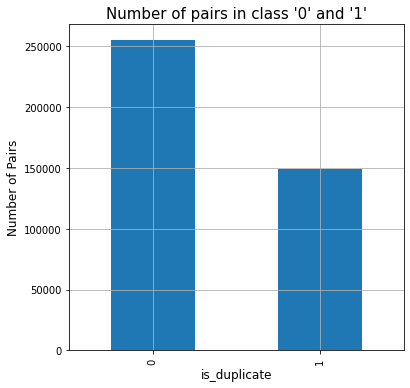

In [46]:
plt.figure(figsize = (6,6))
df.groupby("is_duplicate")['id'].count().plot.bar()
plt.title("Number of pairs in class '0' and '1'", fontsize = 15)
plt.xlabel('is_duplicate', fontsize = 12)
plt.ylabel('Number of Pairs', fontsize = 12)
plt.grid(1)
plt.show()

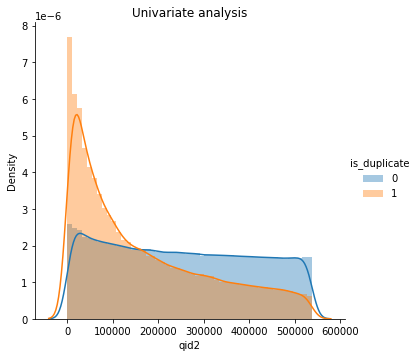

In [47]:
sns.FacetGrid(df, hue="is_duplicate", size=5) \
.map(sns.distplot, "qid2") \
.add_legend();
plt.title('Univariate analysis')
plt.ylabel("Density")
plt.show();

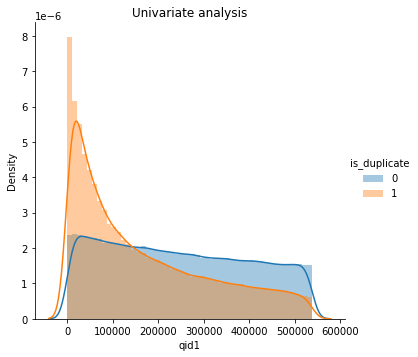

In [48]:
sns.FacetGrid(df, hue="is_duplicate", size=5) \
.map(sns.distplot, "qid1") \
.add_legend();
plt.title('Univariate analysis')
plt.ylabel("Density")
plt.show();

In [49]:
from scipy.stats import bartlett
bartlett(df.qid1,df.qid2)

BartlettResult(statistic=74.18498209762306, pvalue=7.112937020539213e-18)

**ANOVA to check variance**

The one-way ANOVA compares the means between the groups you are interested in and determines whether any of those means are statistically significantly different from each other. Specifically, it tests the null hypothesis:

One-way ANOVA Null Hypothesis where µ = group mean and k = number of groups. If, however, the one-way ANOVA returns a statistically significant result, we accept the alternative hypothesis (HA), which is that there are at least two group means that are statistically significantly different from each other.

The assumptions of one way ANOVA are satisfied.

In [50]:
import scipy.stats as st
#Its more useful when we have numeric features
st.f_oneway(df.qid1,df.qid2)

F_onewayResult(statistic=110.3928026377853, pvalue=8.068525651606139e-26)

We fail to prove that the groups are statistically different from each other.

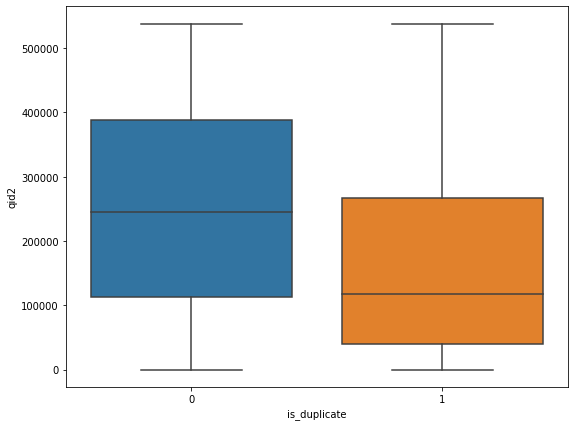

In [51]:
fig,ax = plt.subplots(figsize=(9,7))
sns.boxplot(ax=ax,x=df.is_duplicate,y=df.qid2)

As we can see from boxplot that most our qid1 lies between 100000-400000 for is_dupicate = 0 and 50000-280000 for is_duplicate = 1

In [52]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
nan_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [53]:
#Dropping the NaN value's row
df.dropna(axis=0, how='any', inplace = True)
nan_rows = df[df.isnull().any(1)]
nan_rows.shape

(0, 6)

In [54]:
print('\n~> Question pairs are not Similar (is_duplicate = 0): {}%\n i.e. {} data poins in dataset'
      .format(100 - round(df['is_duplicate'].mean()*100, 2), df[df['is_duplicate'] == 0].shape[0])) 
#using mean because we've class label as 0 or 1
print('\n~> Question pairs are Similar (is_duplicate = 1): {}%\ni.e. {} data points in dataset'
      .format(round(df['is_duplicate'].mean()*100, 2), df[df['is_duplicate'] == 1].shape[0]))


~> Question pairs are not Similar (is_duplicate = 0): 63.08%
 i.e. 255024 data poins in dataset

~> Question pairs are Similar (is_duplicate = 1): 36.92%
i.e. 149263 data points in dataset


In [55]:
test = pd.read_csv("test.csv")

print("Number of data points:",test.shape[0])

Number of data points: 2345796


In [56]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

In [57]:
df["question1"] = df["question1"].fillna("").apply(preprocess)
df["question2"] = df["question2"].fillna("").apply(preprocess)

mean-train 59.97 std-train 32.12 mean-test 60.07 std-test 31.62 max-train 1173.00 max-test 1176.00


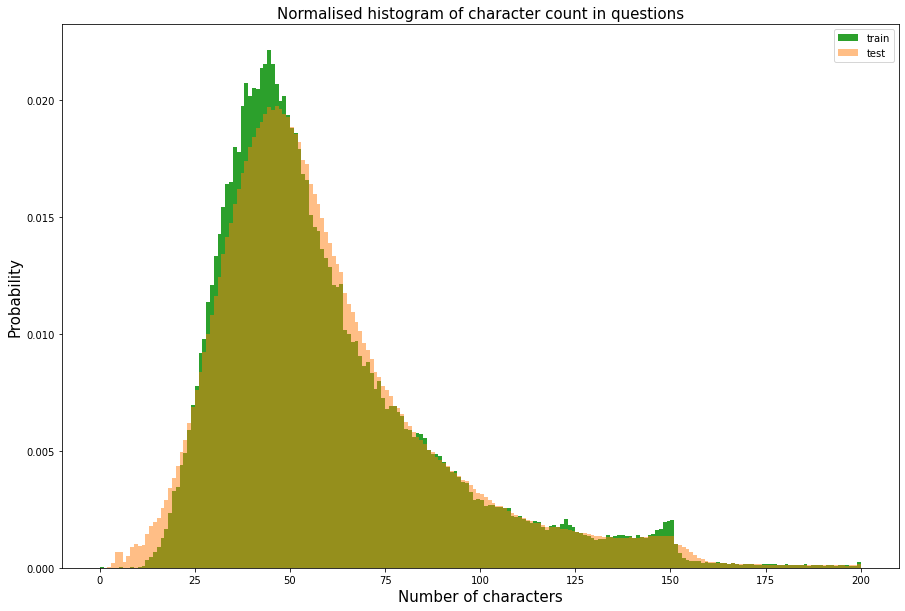

In [58]:
pal = sns.color_palette()
train_qs = pd.Series(df['question1'].tolist() + df['question2'].tolist()).astype(str)
test_qs = pd.Series(test['question1'].tolist() + test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], density=True, stacked= True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], density=True, stacked = True,  alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

We can see that most questions have anywhere from 15 to 150 characters in them. It seems that the test distribution is a little different from the train one, but not too much so (I can't tell if it is just the larger data reducing noise, but it also seems like the distribution is a lot smoother in the test set).

One thing that catches my eye is the steep cut-off at 150 characters for the training set, for most questions, while the test set slowly decreases after 150. Could this be some sort of Quora question size limit?

It's also worth noting that I've truncated this histogram at 200 characters, and that the max of the distribution is at just under 1200 characters for both sets - although samples with over 200 characters are very rare.

Let's do the same for word count. I'll be using a naive method for splitting words (splitting on spaces instead of using a serious tokenizer), although this should still give us a good idea of the distribution.

mean-train 12.71 std-train 6.73 mean-test 11.02 std-test 5.84 max-train 271.00 max-test 238.00


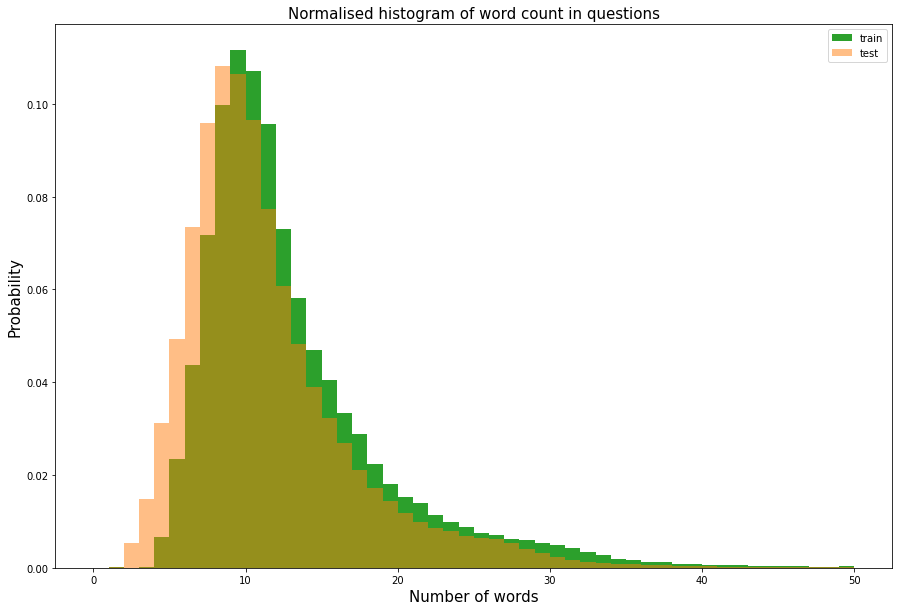

In [59]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], density=True, stacked=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], density=True, stacked=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

We see a similar distribution for word count, with most questions being about 10 words long. It looks to me like the distribution of the training set seems more "pointy", while on the test set it is wider. Nevertheless, they are quite similar.

So what are the most common words? Let's take a look at a word cloud.

(-0.5, 1439.5, 1079.5, -0.5)

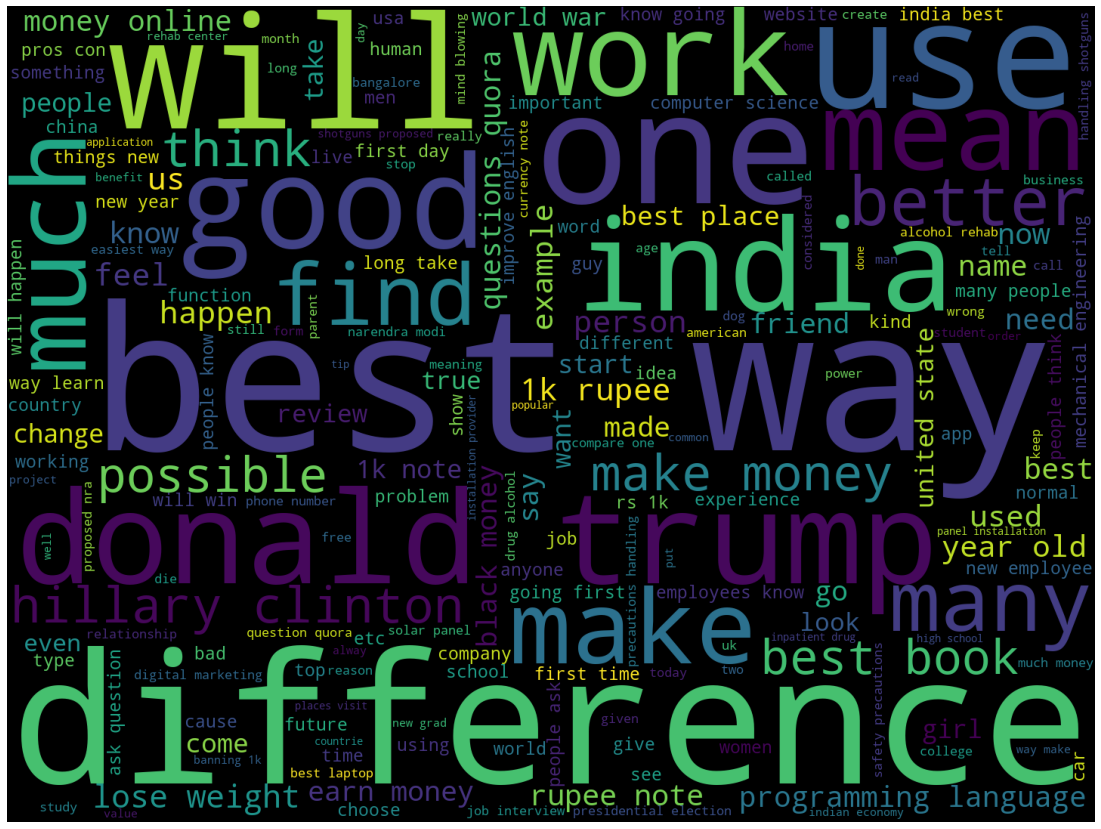

In [60]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

**Semantic Analysis**

Next, I will take a look at usage of different punctuation in questions - this may form a basis for some interesting features later on.

In [64]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))

Questions with question marks: 0.00%
Questions with [math] tags: 0.00%
Questions with full stops: 0.00%


**Feature Analysis**
Before we create a model, we should take a look at how powerful some features are. I will start off with the word share feature from the benchmark model.

Text(0.5, 0, 'word_match_share')

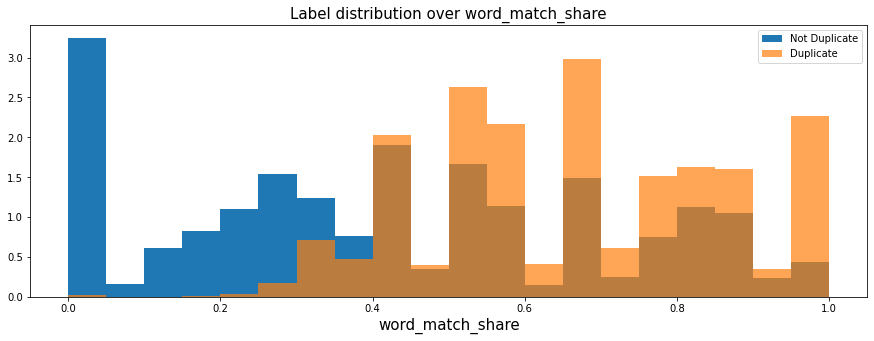

In [65]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for i in (str(row['question1']).lower().split()):
        if i not in stops:
            q1words[i] = 1
    for i in (str(row['question2']).lower().split()):
        if i not in stops:
            q2words[i] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df.apply(word_match_share, axis = 1)
plt.hist(train_word_match[df['is_duplicate'] == 0], bins=20, density = True, stacked=True, label='Not Duplicate')
plt.hist(train_word_match[df['is_duplicate'] == 1], bins=20, density = True, stacked=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

Here we can see that this feature has quite a lot of predictive power, as it is good at separating the duplicate questions from the non-duplicate ones. Interestingly, it seems very good at identifying questions which are definitely different, but is not so great at finding questions which are definitely duplicates.

## Feature Extraction

In [66]:
df['freq_qid1']=df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2']=df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len()
df['q2len']=df['question2'].str.len()
df['q1_n_words']=df['question1'].apply(lambda row:len(row.split(" ")))
df['q2_n_words']=df['question2'].apply(lambda row:len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word:word.lower().strip() , row['question1'].split(" ")))
    w2 = set(map(lambda word:word.lower().strip() , row['question2'].split(" ")))
    return 1.0*len(w1 & w2)
df['word_common'] = df.apply(normalized_word_Common , axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])
df.head()  

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,15,13,12.0,25.0,0.480000,2,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,13,18,8.0,26.0,0.307692,5,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,15,11,5.0,26.0,0.192308,2,0
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,13,19,1.0,22.0,0.045455,2,0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,16,8,5.0,22.0,0.227273,4,2


##Analysis of extracted features

In [67]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 49
Number of Questions with minimum length [question2] : 15


### Feature: Word Share

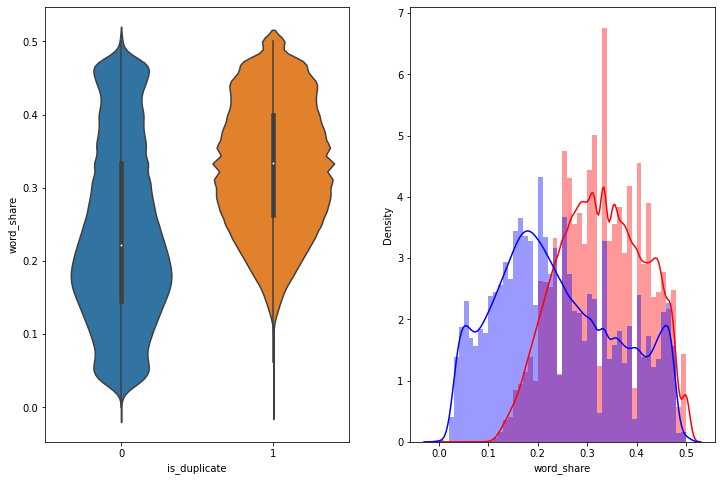

In [68]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

* The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
* The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

### Feature: Word Common

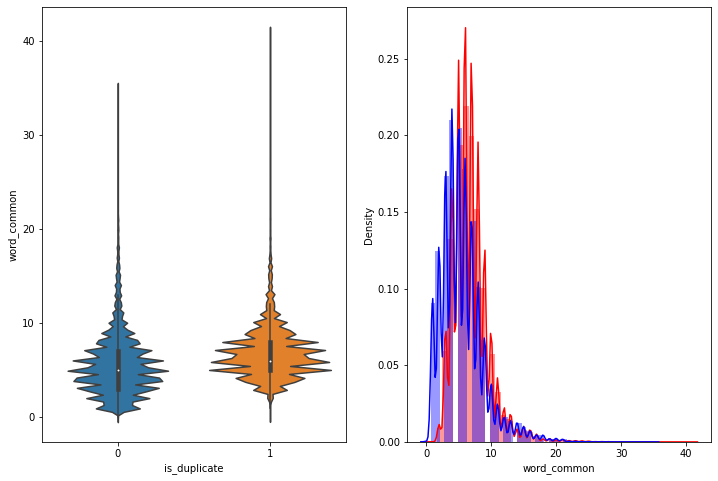

In [69]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_common', data = df[0:]);

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['word_common'][0:] , label='1' , color = 'red');
sns.distplot(df[df["is_duplicate"]==0.0]['word_common'][0:] , label='0',color = 'blue');

The distributions of the word_common feature in similar and non-similar questions are highly overlapping

##TF IDF

I'm now going to try to improve this feature, by using  TF-IDF (term-frequency-inverse-document-frequency). This means that we weigh the terms by how uncommon they are, meaning that we care more about rare words existing in both questions than common one. This makes sense, as for example we care more about whether the word "exercise" appears in both than the word "and" - as uncommon words will be more indicative of the content.

In [70]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [71]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.579427006084868e-06), ('what', 2.988268059598018e-06), ('is', 3.36965824926036e-06), ('i', 4.2865838498666874e-06), ('how', 4.331029225785216e-06), ('a', 4.500369030260481e-06), ('to', 4.633533810896218e-06), ('in', 4.824461951880817e-06), ('do', 5.572023981991218e-06), ('of', 5.886473472607295e-06)]

Least common words and weights: 


[('シ', 9.998000399920016e-05),
 ('し', 9.998000399920016e-05),
 ('dcx3400', 9.998000399920016e-05),
 ('3768', 9.998000399920016e-05),
 ('confederates', 9.998000399920016e-05),
 ('asahi', 9.998000399920016e-05),
 ('oitnb', 9.998000399920016e-05),
 ('essex', 9.998000399920016e-05),
 ('samrudi', 9.998000399920016e-05),
 ('prospering', 9.998000399920016e-05)]

In [72]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

Text(0.5, 0, 'word_match_share')

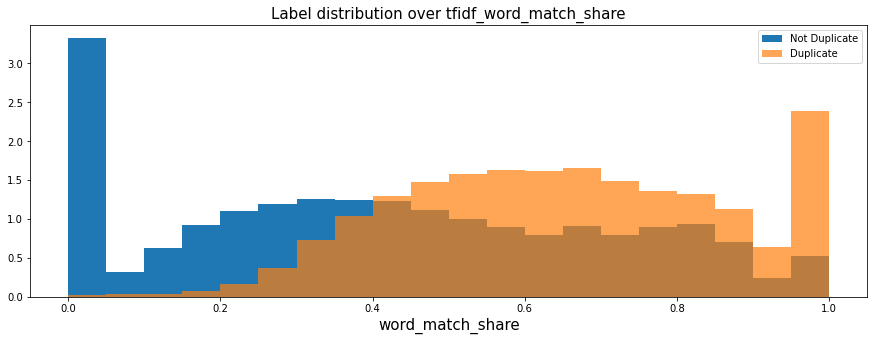

In [73]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df.apply(tfidf_word_match_share, axis=1)
plt.hist(tfidf_train_word_match[df['is_duplicate'] == 0].fillna(0), bins=20, density=True, stacked = True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df['is_duplicate'] == 1].fillna(0), bins=20, density=True, stacked = True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [74]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df['is_duplicate'], train_word_match))
print('TFIDF AUC:', roc_auc_score(df['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.7469869167583065
TFIDF AUC: 0.7368030771581904


So it looks like our TF-IDF actually got worse in terms of overall AUC, which is a bit disappointing. (I am using the AUC metric since it is unaffected by scaling and similar, so it is a good metric for testing the predictive power of individual features.

However, I still think that this feature should provide some extra information which is not provided by the original feature. Our next job is to combine these features and use it to make a prediction. For this, I will use our old friend XGBoost to make a classification model.

###Rebalancing the Data

However, before I do this, I would like to rebalance the data that XGBoost receives, since we have 37% positive class in our training data, and only 17% in the test data. By re-balancing the data so our training set has 17% positives, we can ensure that XGBoost outputs probabilities that will better match the data on the leaderboard, and should get a better score (since LogLoss looks at the probabilities themselves and not just the order of the predictions like AUC)

In [75]:
# First we create our training and testing data
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = test.apply(word_match_share, axis=1)
x_test['tfidf_word_match'] = test.apply(tfidf_word_match_share, axis=1)

y_train = df['is_duplicate'].values

In [76]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.1912434159697727


In [77]:
# Finally, we split some of the data off for validation

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

In [78]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.684029	valid-logloss:0.684056
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.608788	valid-logloss:0.608711
[20]	train-logloss:0.555074	valid-logloss:0.55659
[30]	train-logloss:0.516944	valid-logloss:0.518418
[40]	train-logloss:0.48894	valid-logloss:0.490393
[50]	train-logloss:0.467769	valid-logloss:0.469602
[60]	train-logloss:0.451064	valid-logloss:0.453757
[70]	train-logloss:0.439967	valid-logloss:0.441636
[80]	train-logloss:0.429863	valid-logloss:0.432474
[90]	train-logloss:0.422987	valid-logloss:0.425391
[100]	train-logloss:0.417172	valid-logloss:0.419664
[110]	train-logloss:0.412569	valid-logloss:0.415301
[120]	train-logloss:0.409301	valid-logloss:0.412051
[130]	train-logloss:0.406673	valid-logloss:0.409263
[140]	train-logloss:0.404229	valid-logloss:0.407226
[150]	train-logloss:0.402552	valid-logloss:0.405552
[160]	train-logloss:0.401407	v

In [79]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('finalproject.csv', index=False)